<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/RAndom_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import random
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib',
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset

In [ ]:
#0. Model methods import
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

adata_m1 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/PC_all_genes_qc.h5ad")
adata_m2 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/PC_HVGs_qc.h5ad")
adata_m3 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/no_PC_HVGs_qc.h5ad")

data_list = [adata_m1, adata_m2, adata_m3]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Access the gene names associated with the PCs
gene_names = adata_m1.var_names
print(gene_names)

Index(['RP11-34P13.7', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4',
       'RP5-857K21.2', 'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C',
       'RP11-54O7.16',
       ...
       'RNU2-62P', 'RNU4-42P', 'RN7SKP262', 'RNU6-384P', 'RNU6-893P',
       'RN7SL158P', 'RNU2-41P', 'AC090673.1', 'RNU4-67P', 'RNU6-210P'],
      dtype='object', length=30738)


In [ ]:
# Retrieve the gene names for the first PC
'''
return the indices order that would place the original array values in descending order
arr = np.array([3, 1, 5, 2, 4])
sorted_indices = arr.argsort()[::-1]
print(sorted_indices)
[2 4 0 3 1]
'''
pc1_gene_names = gene_names[np.abs(adata_m1.varm['PCs'][0]).argsort()[::-1]]
pc1_gene_names = pd.DataFrame(pc1_gene_names)

In [ ]:
pc1_gene_names

,0
0,VWA1
1,SAMD11
2,C1orf159
3,RNF223
4,AGRN
5,RP11-54O7.11
6,ISG15
7,HES4
8,RP11-54O7.17
9,PLEKHN1


In [ ]:
df_astro_lr = pd.DataFrame(columns = ['Seed', 'arf m1 val', 'arf m2 val', 'arf m3 val','arf m1 test', 'arf m2 test', 'arf m3 test'])

In [ ]:
dict_list_astro_rf_m1 = []
dict_list_astro_rf_m2 = []
dict_list_astro_rf_m3 = []

In [ ]:
#0. Define Logistic Regression Model
def randomForestTest():

  use_gpu = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_gpu else "cpu")

  forest = RandomForestClassifier(random_state=0,n_estimators = 100)
  forest.fit(X_train, y_train)

  prediction_test = forest.predict(X_test_global)

  #test accruacy
  accuracy_test = accuracy_score(y_test_global, prediction_test)
  print("Test acc = ", accuracy_test)

  return prediction_test, accuracy_test, forest

In [ ]:
#0. Define Logistic Regression Model for Validation
def randomForestValidation():

  use_gpu = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_gpu else "cpu")

  forest = RandomForestClassifier(random_state=0,n_estimators = 100)
  forest.fit(X_train, y_train)
  prediction_val = forest.predict(X_val)

  #validation accuracy
  accuracy_val = metrics.accuracy_score(y_val, prediction_val)
  print("Validation acc = ", metrics.accuracy_score(y_val, prediction_val))

  return prediction_val, accuracy_val

In [ ]:
def plot(y_test, prediction_test):
  confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)
  cmd = ConfusionMatrixDisplay(confusion_matrix, display_labels=['Healthy','PD'])
  cmd.plot(cmap = 'YlGnBu', colorbar = False)

  plt.grid(False)

  fig = cmd.ax_.get_figure()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  plt.rcParams["figure.dpi"] = 500
  plt.rcParams["axes.labelcolor"] = 'black' #now useless

  plt.rc('font', size=16)
  # Set the axes title font size
  plt.rc('axes', titlesize=14)
  # Set the axes labels font size
  plt.rc('axes', labelsize=14)
  # Set the font size for x tick labels
  plt.rc('xtick', labelsize=14)
  # Set the font size for y tick labels
  plt.rc('ytick', labelsize=14)
  #plt.savefig(dpi = 300, fname = 'astro_LR.png')

mega-loop!

In [ ]:
i = 0 #method number
seed_list = []

for dataobj in data_list:
  i = i + 1
  adata = dataobj

  #1. Pre-process data
  if 'level_0' not in adata.obs.columns:
    adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

  if 'X_pca' in adata.obsm:
    X = adata.obsm['X_pca'].X
  else:
    X = adata.X

  y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

  #2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
  #   Parameters for the highest accuracy can be used for test set.

  X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same

  #3. run 10 iterations of the
  for m in range (10):
    # X_test = copy.deepcopy(X_test_global)
    # y_test = copy.deepcopy(y_test_global)

    if len(seed_list) < 10:
      seed = random.randint(0, 9999)
      seed_list.append(seed)
      print("seed: ", seed)
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
    else:
      print("seed = ", seed)
      print(seed_list[m])
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])


    print(X_train.shape, X_test_global.shape)
    prediction_val, accuracy_val = randomForestValidation()
    prediction_test, accuracy_test, forest = randomForestTest()

    if i == 1: #write in method 1 section
      row_dict_m1 = {'Seed': seed_list[m], 'arf m1 val': accuracy_val, 'arf m1 test': accuracy_test}
      dict_list_astro_rf_m1.append(row_dict_m1)
    elif i == 2:
      row_dict_m2 = {'Seed': seed_list[m], 'arf m2 val': accuracy_val, 'arf m2 test': accuracy_test}
      dict_list_astro_rf_m2.append(row_dict_m2)
    elif i == 3:
      row_dict_m3 = {'Seed': seed_list[m], 'arf m3 val': accuracy_val, 'arf m3 test': accuracy_test}
      dict_list_astro_rf_m3.append(row_dict_m3)

return

print(dict_list_astro_rf_m1)
print(dict_list_astro_rf_m2)
print(dict_list_astro_rf_m3)

seed:  7373
(15011, 50) (5004, 50)
Validation acc =  0.988009592326139
Test acc =  0.986810551558753
seed:  29
(15011, 50) (5004, 50)
Validation acc =  0.9872102318145484
Test acc =  0.9856115107913669
seed:  371
(15011, 50) (5004, 50)
Validation acc =  0.9886091127098321
Test acc =  0.988009592326139
seed:  1806
(15011, 50) (5004, 50)
Validation acc =  0.9870103916866507
Test acc =  0.9872102318145484
seed:  2279
(15011, 50) (5004, 50)
Validation acc =  0.9878097521982414
Test acc =  0.9862110311750599
seed:  9777
(15011, 50) (5004, 50)
Validation acc =  0.9878097521982414
Test acc =  0.9850119904076738
seed:  5696
(15011, 50) (5004, 50)
Validation acc =  0.9854116706634692
Test acc =  0.986810551558753
seed:  5581
(15011, 50) (5004, 50)
Validation acc =  0.9840127897681854
Test acc =  0.9848121502797762
seed:  1275
(15011, 50) (5004, 50)
Validation acc =  0.9884092725819345
Test acc =  0.9870103916866507
seed:  6148
(15011, 50) (5004, 50)
Validation acc =  0.9876099120703438
Test acc

KeyboardInterrupt: ignored

In [ ]:
df_astro_m1 = pd.DataFrame.from_dict(dict_list_astro_rf_m1)
df_astro_m2 = pd.DataFrame.from_dict(dict_list_astro_rf_m2)
df_astro_m3 = pd.DataFrame.from_dict(dict_list_astro_rf_m3)

In [ ]:
print(df_astro_m1)
print(df_astro_m2)

In [ ]:
f = pd.concat([df_astro_m1, df_astro_m2,df_astro_m3])
f

In [ ]:
#4. Re-run Logistic Regression with the seed that generates the highest acc to draw plot
# chosenseedm1=df_astro_m1['Seed'][df_astro_m1['arf m1 test'].idxmax()]
# print(chosenseedm1)
if 'X_pca' in adata_m1.obsm:
  X = pd.DataFrame(adata_m1.obsm['X_pca'].X)
else:
  X = adata_m1.X

y = adata_m1.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
#   Parameters for the highest accuracy can be used for test set.

X_train, X_test_global, y_train, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

prediction_test, accuracy_test, forest = randomForestTest()
plot(y_test_global, prediction_test)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
i = 0 #method number
seed_list = [] #create a list to store the seed

for dataobj in data_list:
  i = i + 1
  adata = dataobj

  #1. Pre-process data
  if 'level_0' not in adata.obs.columns:
    adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

  if 'X_pca' in adata.obsm:
    X = adata.obsm['X_pca'].X
  else:
    X = adata.X

  y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

  #2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
  #   Parameters for the highest accuracy can be used for test set.

  X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same

  #3. run 10 iterations
  for m in range (10):
    # X_test = copy.deepcopy(X_test_global)
    # y_test = copy.deepcopy(y_test_global)

    if len(seed_list) < 10: #check # of iter ran
      seed = random.randint(0, 9999) #generate a random seed
      seed_list.append(seed) #
      print("seed: ", seed)
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
    else:
      print("seed = ", seed)
      print(seed_list[m])
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])


    print(X_train.shape, X_test_global.shape)
    prediction_val, accuracy_val = randomForestValidation()
    prediction_test, accuracy_test, forest = randomForestTest()

    if i == 1: #write in method 1 section
      row_dict_m1 = {'Seed': seed_list[m], 'arf m1 val': accuracy_val, 'arf m1 test': accuracy_test}
      dict_list_astro_rf_m1.append(row_dict_m1)
    elif i == 2:
      row_dict_m2 = {'Seed': seed_list[m], 'arf m2 val': accuracy_val, 'arf m2 test': accuracy_test}
      dict_list_astro_rf_m2.append(row_dict_m2)
    elif i == 3:
      row_dict_m3 = {'Seed': seed_list[m], 'arf m3 val': accuracy_val, 'arf m3 test': accuracy_test}
      dict_list_astro_rf_m3.append(row_dict_m3)

return

#####**feature importance**

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
forest.feature_importances_

array([0.24915787, 0.04538757, 0.06721471, 0.05539373, 0.11162881,
       0.03198195, 0.0427673 , 0.00941563, 0.01301971, 0.02309605,
       0.03082494, 0.00719543, 0.01264392, 0.01378542, 0.0378614 ,
       0.00710373, 0.01209004, 0.00493864, 0.01077598, 0.00953214,
       0.01928418, 0.03355134, 0.00632323, 0.01385906, 0.00480505,
       0.00590758, 0.01906461, 0.00461743, 0.00600446, 0.00408277,
       0.00384214, 0.00675215, 0.00683033, 0.00393719, 0.00438614,
       0.00462053, 0.00376405, 0.00401687, 0.00393472, 0.00668556,
       0.00427128, 0.00342064, 0.00420247, 0.00401305, 0.00407498,
       0.00333447, 0.00405275, 0.00373769, 0.00342856, 0.00337976])

In [ ]:
perm_importance = permutation_importance(forest, X_test_global, y_test_global)

In [ ]:
perm_importance

In [ ]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
print(feature_names)

['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9', 'feature 10', 'feature 11', 'feature 12', 'feature 13', 'feature 14', 'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19', 'feature 20', 'feature 21', 'feature 22', 'feature 23', 'feature 24', 'feature 25', 'feature 26', 'feature 27', 'feature 28', 'feature 29', 'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34', 'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39', 'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44', 'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49']


In [ ]:
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [ ]:
select.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

 Get the integer index of the features selected. If indices is False, this is a boolean array of shape `[# input features]`, in which an element is True iff its corresponding feature is selected for retention. If indices is True, this is an integer array of shape `[# output features] `whose values are indices into the input feature vector.

In [ ]:
select.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [ ]:
selected_feat= X_train.columns[(select.get_support())] #look for indexes selected features in the X_train columns.
print(len(selected_feat)) #gives number of selected features
print(selected_feat) #gives indexes of selected features

12
Int64Index([0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 21, 26], dtype='int64')


In [ ]:
selected_feat = selected_feat.to_numpy() #convert the list into a numpy array
print(selected_feat) #this array starts from i = 0, but in scanpy the index starts from i = 1

[ 0  1  2  3  4  5  6  9 10 14 21 26]


In [ ]:
selected_feat = selected_feat+1 #add 1 to all the list index so that we can access pca plot as the (i+1)th "PCs" in the pca_loading function

Plot the most used genes from each of the selected features(PCs). Parameters are adjustable (ex. can change n_points to show all or selected number of genes)

In [ ]:
fig = sc.pl.pca_loadings(adata_m1, components = selected_feat, include_lowest = True, n_points = 5, save ='most_used_genes.png' )

Rank genes according to contributions to PCs.

####**Find the feature importance of the model Part 2.**
This part of code looks at feature importances using the scikit learn method.

---

In [ ]:
feature_names = [f"feature {i+1}" for i in range(X.shape[1])]
print(feature_names)

['feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9', 'feature 10', 'feature 11', 'feature 12', 'feature 13', 'feature 14', 'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19', 'feature 20', 'feature 21', 'feature 22', 'feature 23', 'feature 24', 'feature 25', 'feature 26', 'feature 27', 'feature 28', 'feature 29', 'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34', 'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39', 'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44', 'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49', 'feature 50']


In [ ]:
index = X.columns
print(index) #feature name is a list of indexes

RangeIndex(start=0, stop=50, step=1)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.023 seconds


This part of code ranks the 50 PCs from least important to most important. You can compare this with the plot of PCs from above.

<Axes: >

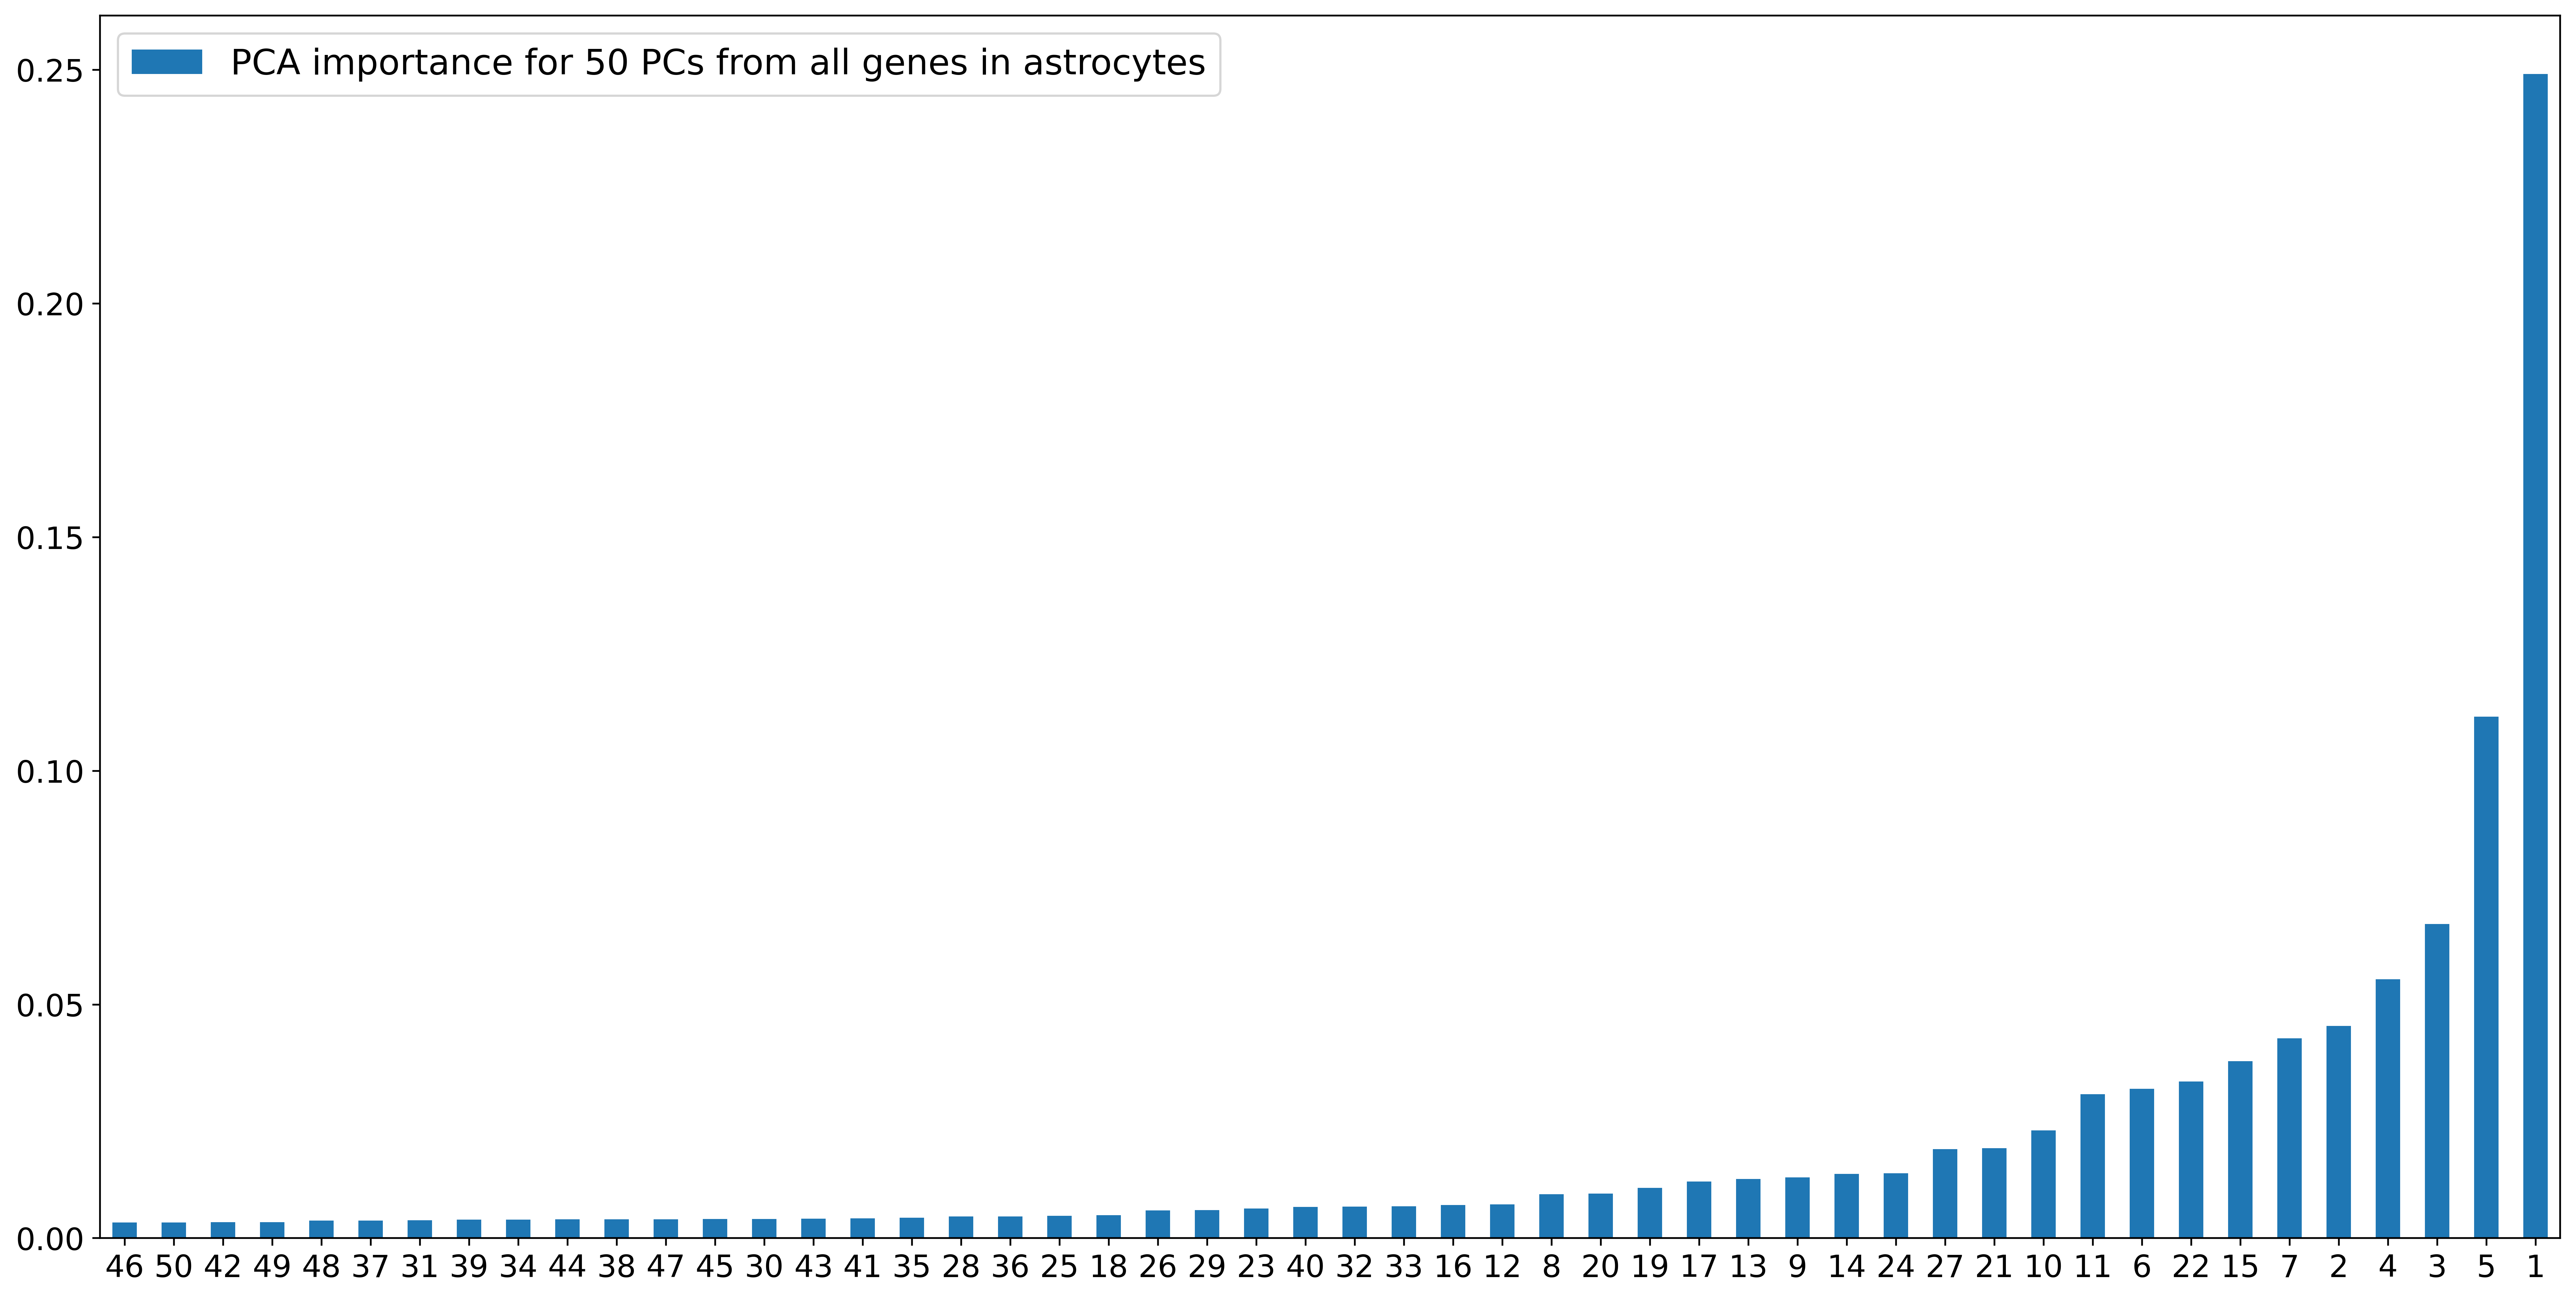

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns+1, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair

imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'PCA importance for 50 PCs from all genes in astrocytes'})
imp.sort_values(by='PCA importance for 50 PCs from all genes in astrocytes').plot(kind='bar', figsize=(20, 10), rot=0)

In [ ]:
print(importances)

[0.24915787 0.04538757 0.06721471 0.05539373 0.11162881 0.03198195
 0.0427673  0.00941563 0.01301971 0.02309605 0.03082494 0.00719543
 0.01264392 0.01378542 0.0378614  0.00710373 0.01209004 0.00493864
 0.01077598 0.00953214 0.01928418 0.03355134 0.00632323 0.01385906
 0.00480505 0.00590758 0.01906461 0.00461743 0.00600446 0.00408277
 0.00384214 0.00675215 0.00683033 0.00393719 0.00438614 0.00462053
 0.00376405 0.00401687 0.00393472 0.00668556 0.00427128 0.00342064
 0.00420247 0.00401305 0.00407498 0.00333447 0.00405275 0.00373769
 0.00342856 0.00337976]


**Feature importance based on mean decrease in impurity**: This approach directly measures feature importance by observing how random re-shuffling (thus preserving the distribution of the variable) of each predictor influences model performance.

(50,)
(10,)


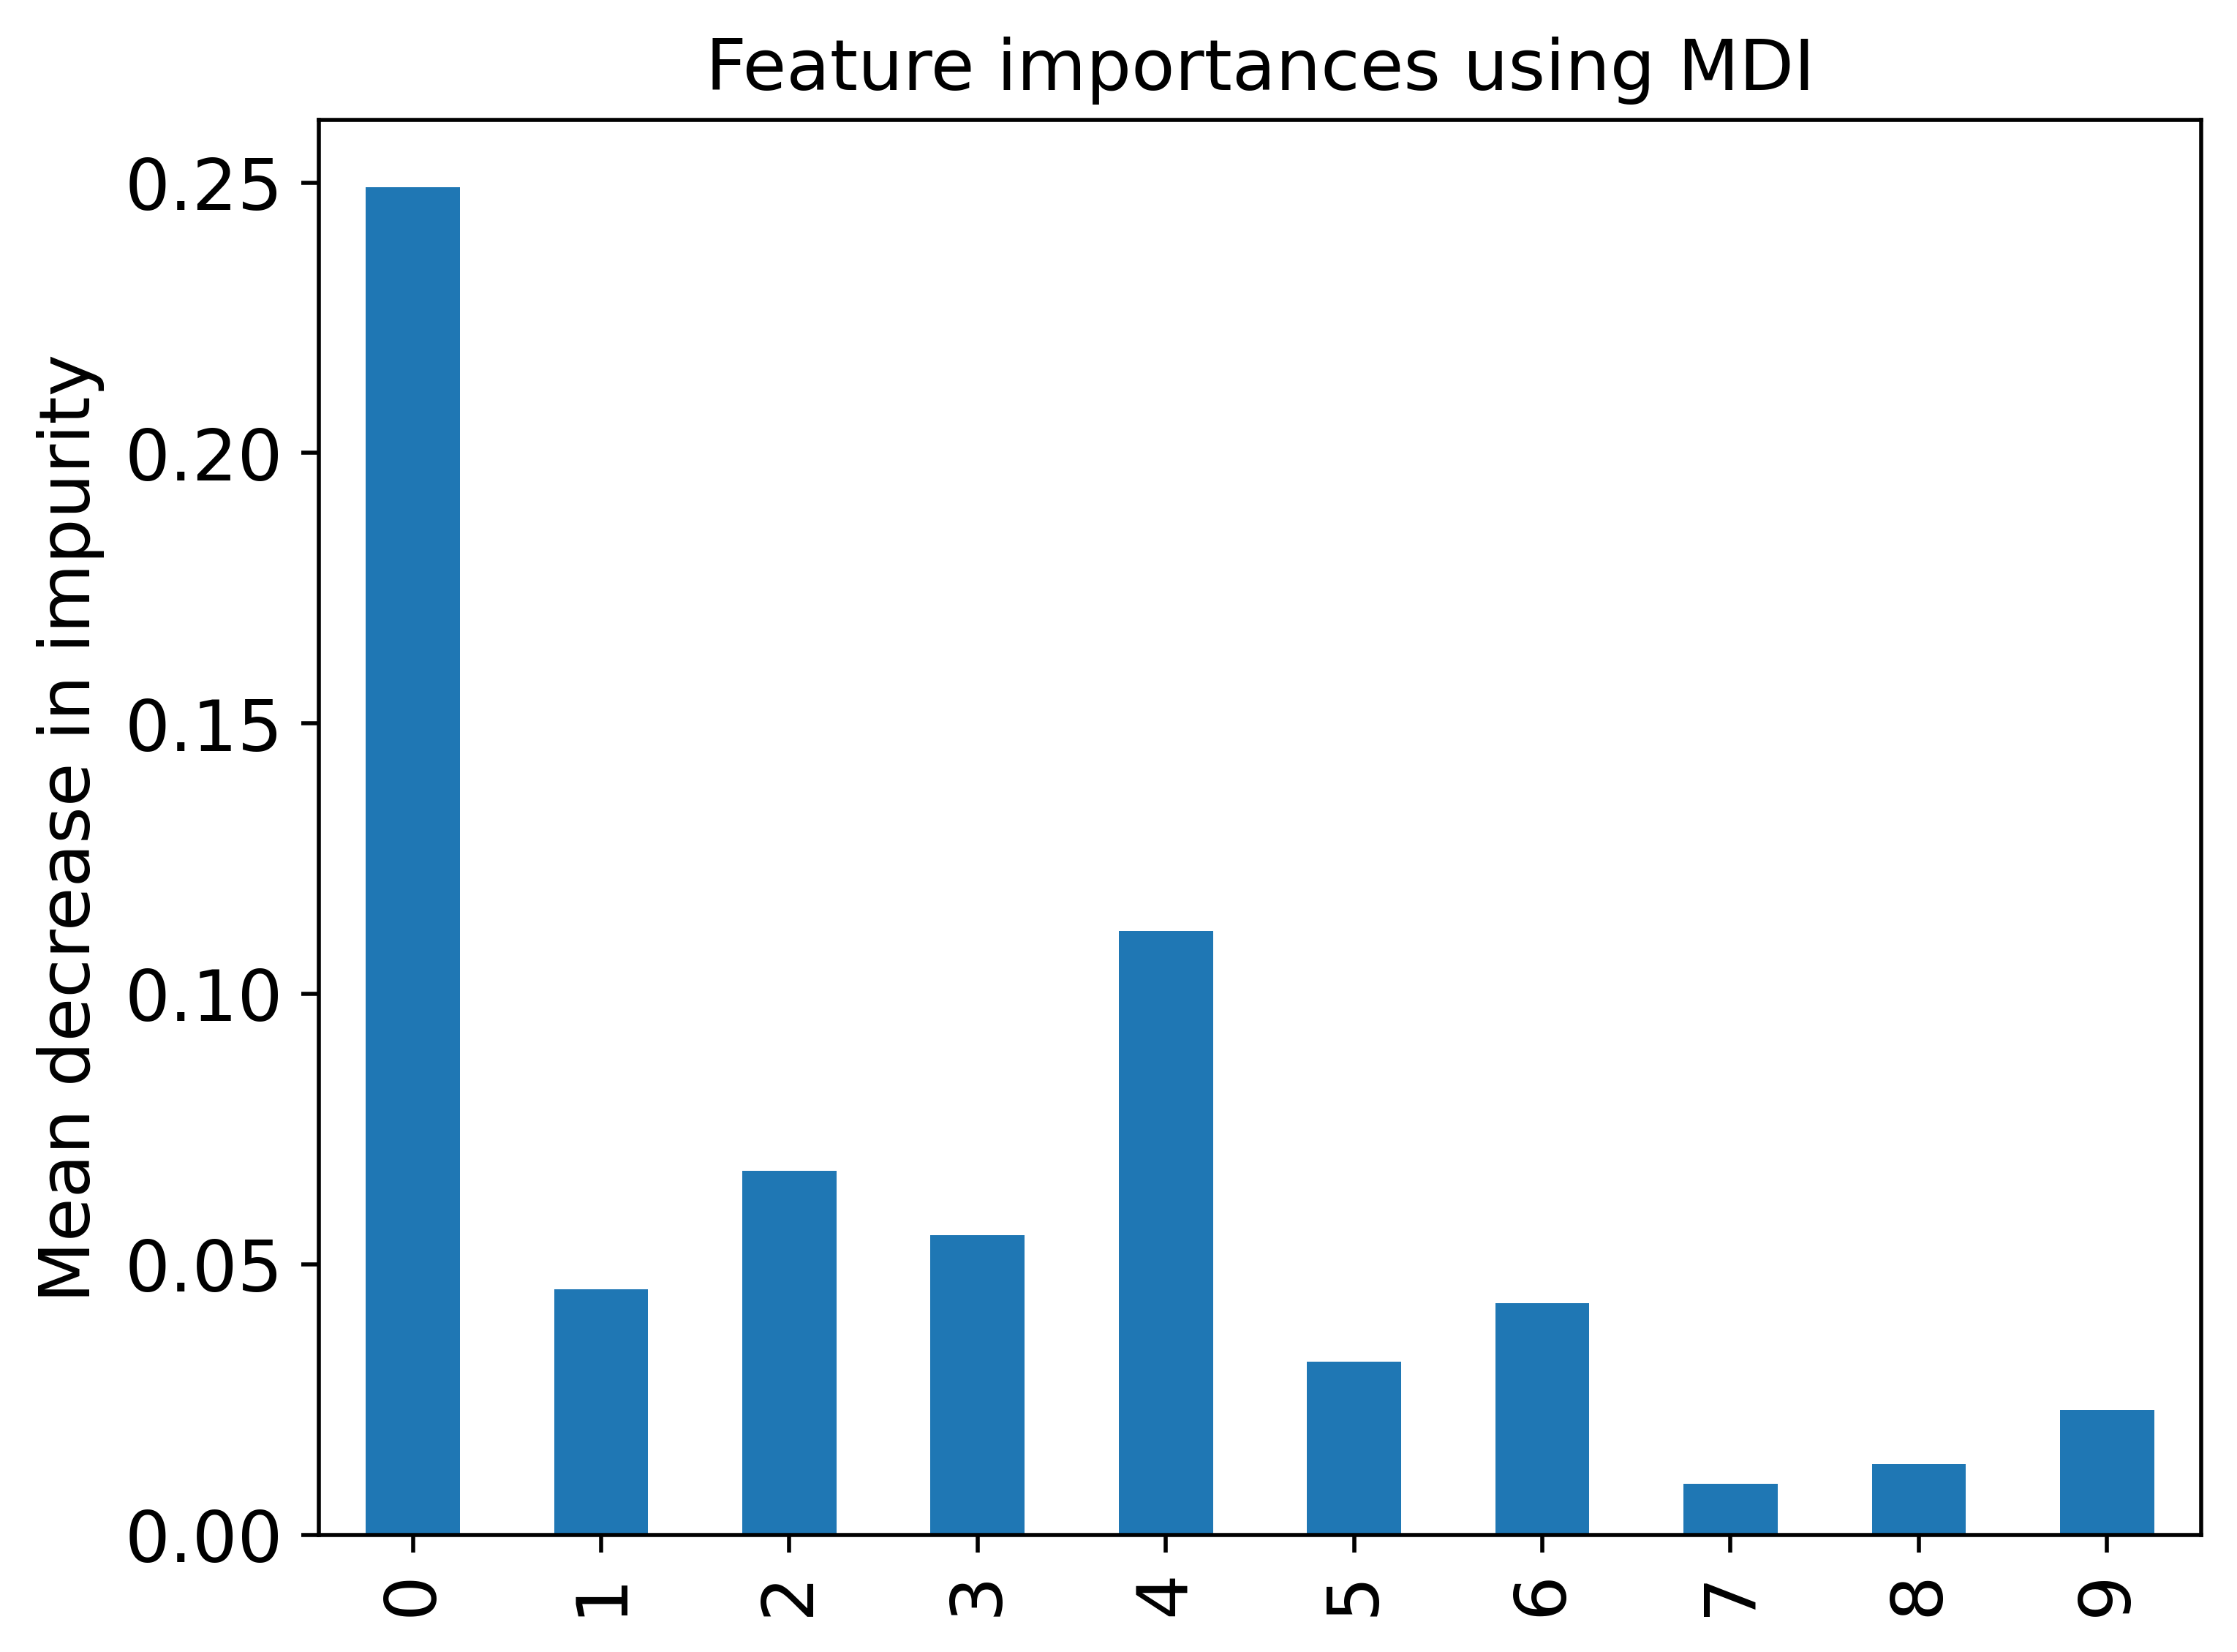

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=None) #series containing importances of each feature
print(forest_importances.shape)
top_importances = forest_importances.take([0,1,2,3,4,5,6,7,8,9], axis = 0) #take the top ten importances from the pandas series
print(top_importances.shape)

fig, ax = plt.subplots()
top_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Permutation feature importance**: The permutation feature importance is defined to compute how much each feature contributes to decreasing the weighted impurity. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. [Check out full explanation here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

In [ ]:
print(forest_importances)

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test_global, y_test_global, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 41.449 seconds


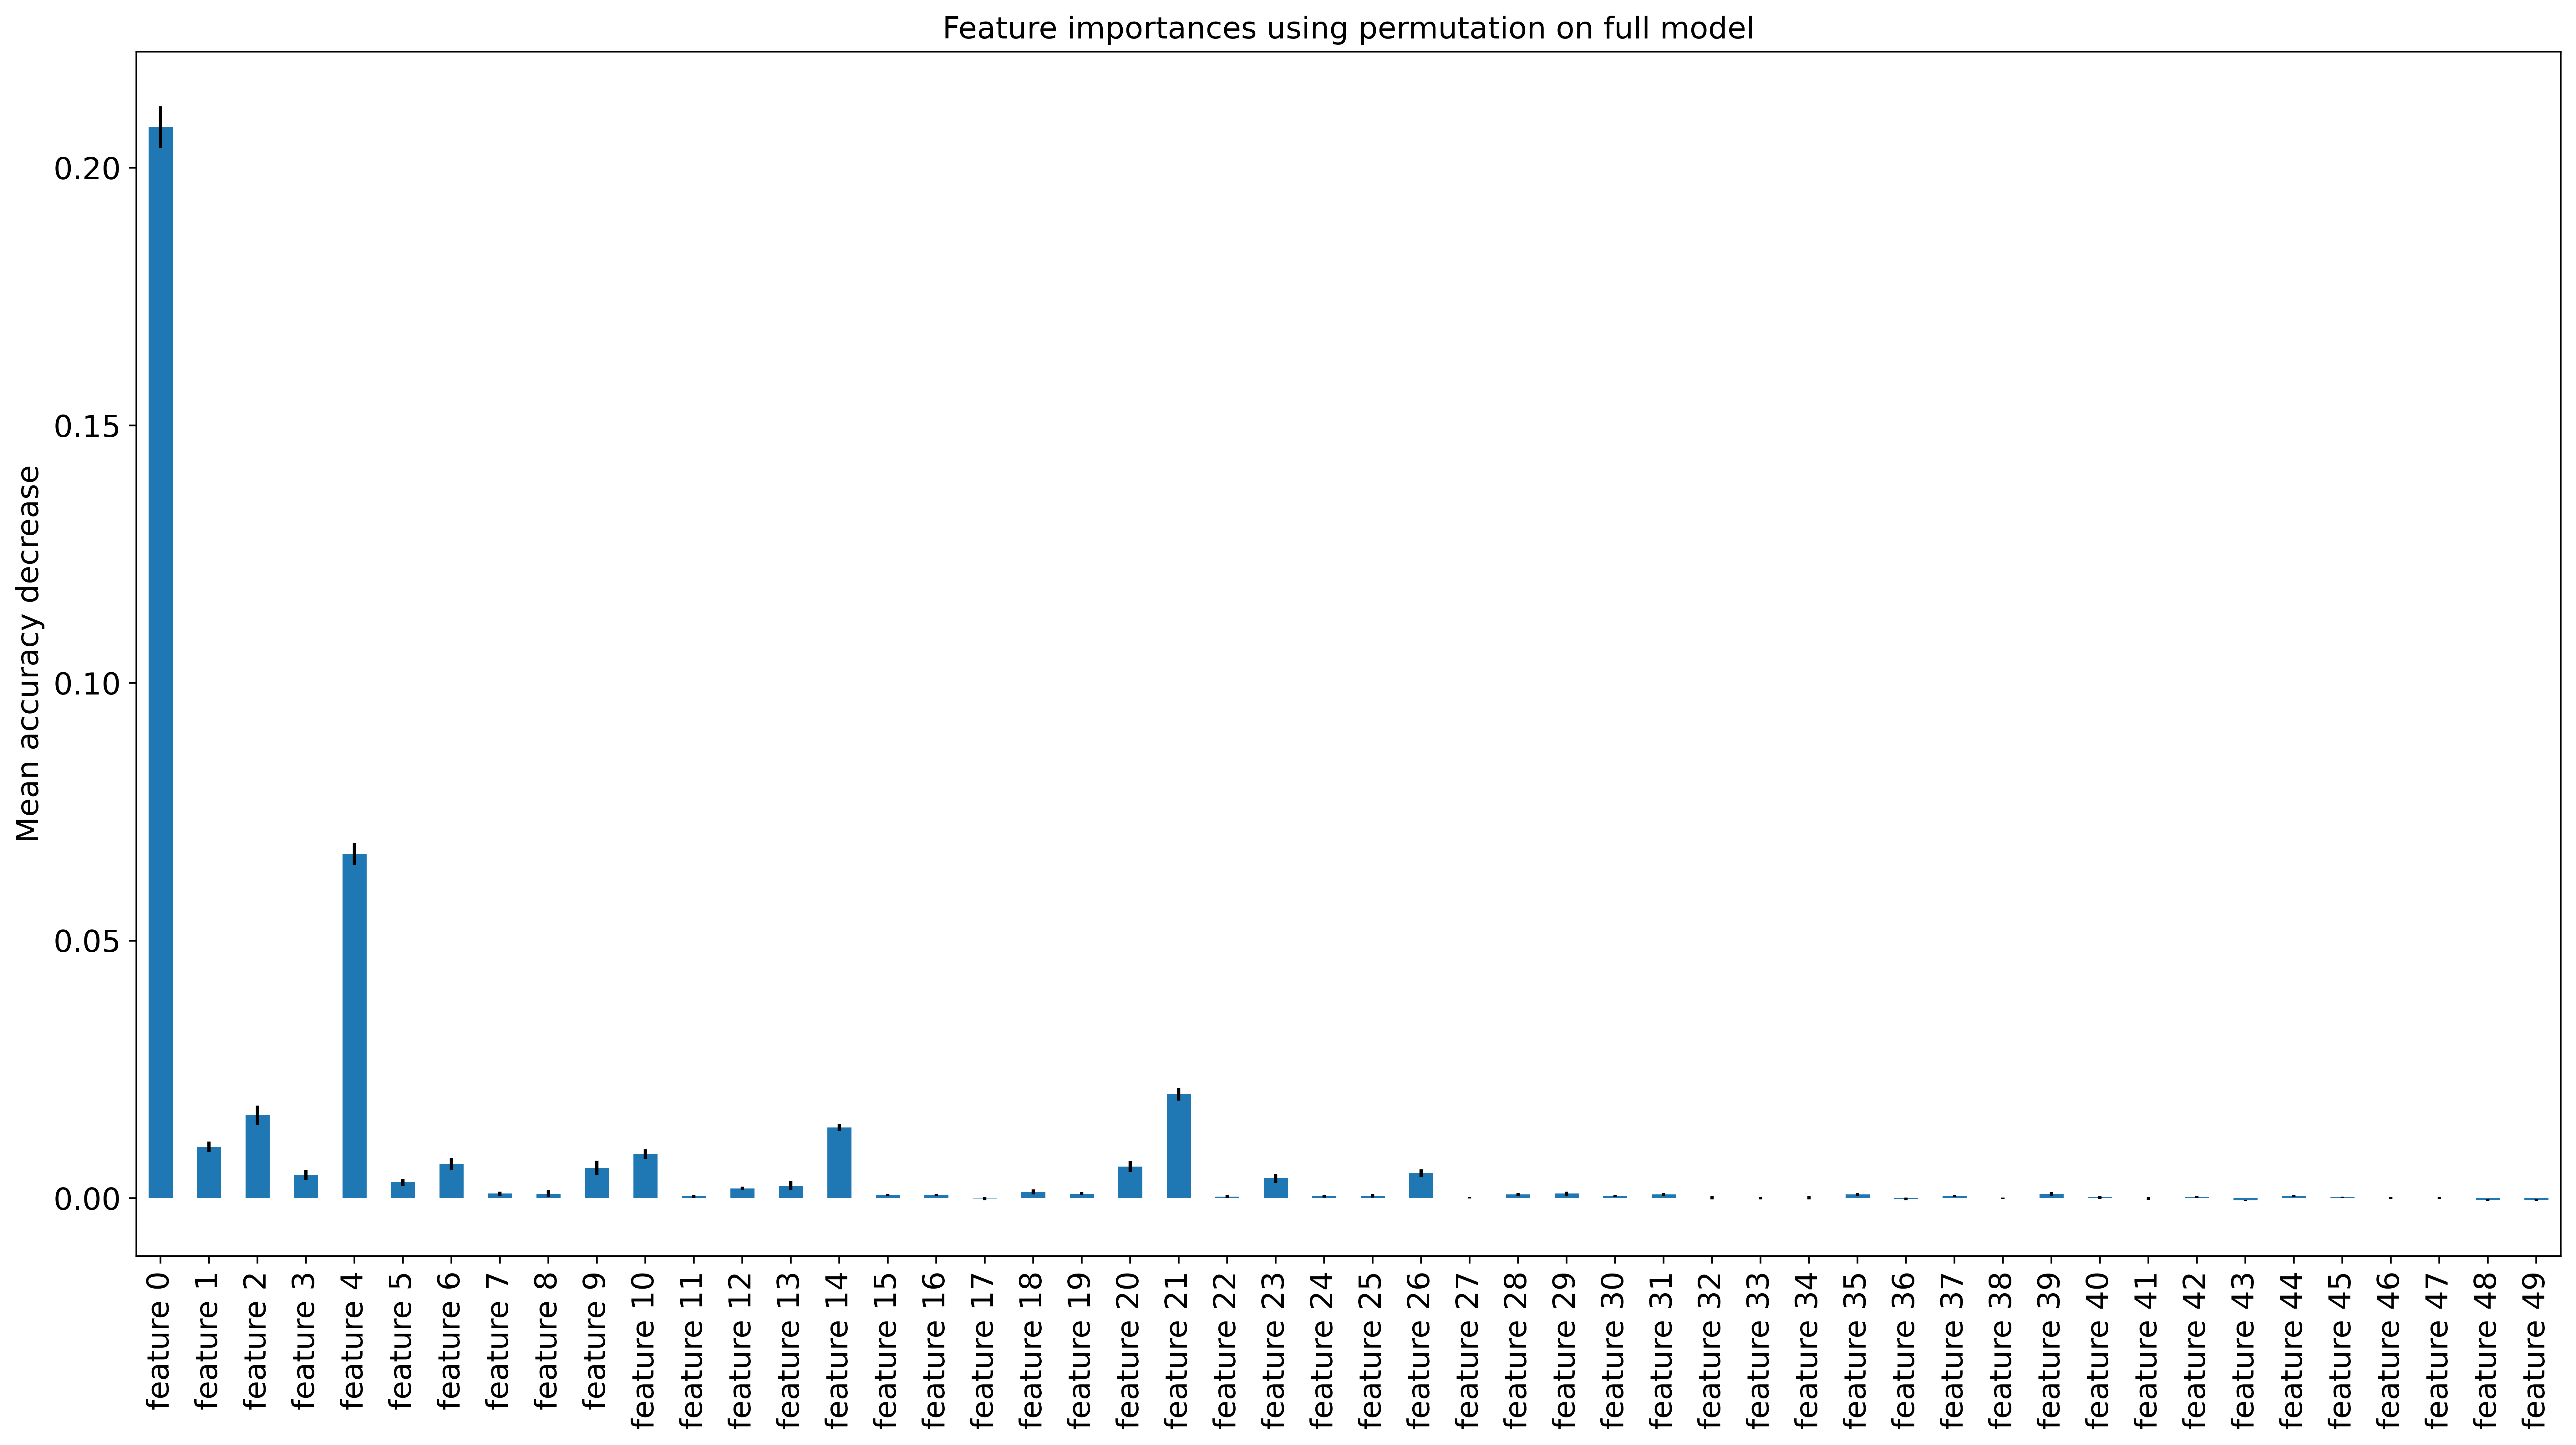

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, figsize=(20, 10))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
#fig.tight_layout()
plt.show()

In [ ]:
#run this on a single cell
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.41109642, 0.083418  , 0.08813749, 0.01525097, 0.09843463,
       0.0150504 , 0.01851981, 0.00453677, 0.00730055, 0.01251374,
       0.01167764, 0.00237583, 0.00614235, 0.00783339, 0.05825377,
       0.00300005, 0.00470664, 0.00350861, 0.01090345, 0.00398166,
       0.01551155, 0.04108424, 0.00171912, 0.0086028 , 0.00152704,
       0.0034978 , 0.01783953, 0.00180495, 0.00338892, 0.00220076,
       0.00131113, 0.00488832, 0.00369457, 0.00219572, 0.00197163,
       0.00174595, 0.00135394, 0.0015938 , 0.00138683, 0.00199757,
       0.00115595, 0.00138362, 0.002004  , 0.00141514, 0.00113478,
       0.00162817, 0.00132345, 0.0011009 , 0.00147946, 0.00141619])

#####**PCA making**
How to make the PCs to include the feature_names of the genes? If it contains that, I can print out the name on a bar plot.

In [ ]:
raw = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/new_anndata.h5ad")

In [ ]:
sc.pl.pca_loadings(adata_m1)

In [ ]:
sc.pl.pca_overview(adata_m1)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
adata_m1.varm['PCs']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
forest.feature_importances_

array([0.25123582, 0.03926989, 0.06063533, 0.06329908, 0.11280668,
       0.03295712, 0.04239421, 0.01037342, 0.01353542, 0.02158422,
       0.02777234, 0.00751607, 0.01322971, 0.01578077, 0.04072069,
       0.00697755, 0.01322321, 0.00509598, 0.01028181, 0.00879368,
       0.01931089, 0.03295077, 0.00613895, 0.01279277, 0.00593234,
       0.00536787, 0.01935277, 0.00453434, 0.00598111, 0.00409687,
       0.00418837, 0.00578552, 0.00732107, 0.00430598, 0.00452579,
       0.00440828, 0.00370945, 0.00423288, 0.00393576, 0.00591117,
       0.00419094, 0.0034754 , 0.00423089, 0.00347228, 0.0040538 ,
       0.00355428, 0.00440331, 0.00340228, 0.00350616, 0.00344473])

In [ ]:
adata_m1.var_names

Index(['RP11-34P13.7', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4',
       'RP5-857K21.2', 'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C',
       'RP11-54O7.16',
       ...
       'RNU2-62P', 'RNU4-42P', 'RN7SKP262', 'RNU6-384P', 'RNU6-893P',
       'RN7SL158P', 'RNU2-41P', 'AC090673.1', 'RNU4-67P', 'RNU6-210P'],
      dtype='object', length=30738)

In [ ]:
plt.barh(adata_m1.var_names, forest.feature_importances_)

In [ ]:
import scanpy as sc
import pandas as pd
# Assuming 'adata' is your AnnData object containing the gene contributions
# Set the number of top PCs and top genes to display
num_pcs = 50
num_genes = 20
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['PC', 'Up genes', 'Down genes'])
# Iterate over the top PCs
for pc in range(num_pcs):
    # Get the gene contributions for the current PC
    gene_contributions = new.uns['rank_genes_groups']['scores'][pc]
    # Extract the top up and down genes
    up_genes = gene_contributions[:num_genes]
    down_genes = gene_contributions[-num_genes:][::-1]
    # Add the results to the DataFrame
    results_df = results_df.append({'PC': pc+1, 'Up genes': up_genes, 'Down genes': down_genes}, ignore_index=True)
# Print the results
print(results_df)

KeyError: ignored

In [ ]:
new = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/new_anndata.h5ad")

In [ ]:
new.uns

OrderedDict()

In [ ]:
adata_m1.uns

{'hvg': {'flavor': 'seurat'},
 'log1p': {},
 'pca': {'params': {'use_highly_variable': True, 'zero_center': True},
  'variance': array([76.2841   , 48.33228  , 34.0483   , 21.22835  , 17.27191  ,
         15.002582 , 13.484277 , 12.2012415, 10.264885 ,  8.265003 ,
          7.37268  ,  6.8865204,  6.4328713,  5.5463085,  5.126185 ,
          5.069711 ,  4.716357 ,  4.5221286,  4.2180815,  4.023639 ,
          3.887671 ,  3.6637843,  3.4942653,  3.3564043,  3.202494 ,
          3.0846312,  3.038085 ,  2.9560556,  2.8808818,  2.7608056,
          2.7282672,  2.6702926,  2.638003 ,  2.5752473,  2.5065925,
          2.4301167,  2.3814802,  2.3751607,  2.2820234,  2.2620287,
          2.2226176,  2.191705 ,  2.158612 ,  2.141834 ,  2.1091669,
          2.0967603,  2.066707 ,  2.042912 ,  2.0231586,  2.0067766],
        dtype=float32),
  'variance_ratio': array([0.01803862, 0.01142896, 0.00805128, 0.00501979, 0.00408422,
         0.0035476 , 0.00318858, 0.00288518, 0.0024273 , 0.00195439,
  

In [ ]:
#4. Re-run Logistic Regression with the seed that generates the highest acc to draw plot
# chosenseedm2=df_astro_m2['Seed'][df_astro_m2['arf m2 test'].idxmax()]
if 'X_pca' in adata_m2.obsm:
  X = adata_m2.obsm['X_pca'].X
else:
  X = adata_m2.X

y = adata_m2.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
#   Parameters for the highest accuracy can be used for test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm2)

prediction_test, accuracy_test = randomForestTest()
plot(y_test, prediction_test)

In [ ]:
#4. Re-run Logistic Regression with the seed that generates the highest acc to draw plot
# chosenseedm3=df_astro_m3['Seed'][df_astro_m3['arf m3 test'].idxmax()]
if 'X_pca' in adata_m3.obsm:
  X = adata_m3.obsm['X_pca'].X
else:
  X = pd.DataFrame(adata_m3.X, columns =

y = adata_m3.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
#   Parameters for the highest accuracy can be used for test set.

X_train, X_test_global, y_train, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

prediction_test, accuracy_test, forest = randomForestTest()
plot(y_test_global, prediction_test)

####**Write 2500 HVGs into CSV**

In [ ]:
adata_m3.X

array([[-0.0309737 , -0.29745266,  0.04296768, ..., -0.0169951 ,
        -0.00773758, -0.07200374],
       [-0.03005852, -0.28993848,  0.03852411, ..., -0.01743799,
        -0.00831135, -0.06919986],
       [-0.03324657,  2.1722908 ,  0.04349804, ..., -0.01791944,
        -0.01077041, -0.07682869],
       ...,
       [-0.02114401, -0.2095565 , -0.01181161, ..., -0.02311098,
        -0.01689282, -0.04045262],
       [-0.03016218, -0.24396938, -0.0069039 , ..., -0.02623838,
        -0.02773676, -0.06016752],
       [-0.0467868 , -0.32860914,  0.02294184, ..., -0.02799591,
        -0.03890149, -0.10074496]], dtype=float32)

In [ ]:
adata_m3

AnnData object with n_obs × n_vars = 25019 × 2500
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [ ]:
df = pd.DataFrame(adata_m3.var['highly_variable'])

In [ ]:
!mkdir write

In [ ]:
variable_genes_m3 = 'write/variable_genes_astrom3'

In [ ]:
df.to_csv(variable_genes_m3)

####**Find the feature importance of the model Part 2.**
This part of code looks at feature importances using the scikit learn method.

---

In [ ]:
feature_names_m3 = [f"feature {i+1}" for i in range(X.shape[1])]
print(feature_names_m3)

['feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9', 'feature 10', 'feature 11', 'feature 12', 'feature 13', 'feature 14', 'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19', 'feature 20', 'feature 21', 'feature 22', 'feature 23', 'feature 24', 'feature 25', 'feature 26', 'feature 27', 'feature 28', 'feature 29', 'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34', 'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39', 'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44', 'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49', 'feature 50', 'feature 51', 'feature 52', 'feature 53', 'feature 54', 'feature 55', 'feature 56', 'feature 57', 'feature 58', 'feature 59', 'feature 60', 'feature 61', 'feature 62', 'feature 63', 'feature 64', 'feature 65', 'feature 66', 'feature 67', 'feature 68', 'feature 69', 'feature 70', 'feature 71', 'feature 72', 

In [ ]:
X = pd.DataFrame(X)

In [ ]:
index = X.columns
print(index) #feature name is a list of indexes

RangeIndex(start=0, stop=2500, step=1)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.024 seconds


This part of code ranks the 50 PCs from least important to most important. You can compare this with the plot of PCs from above.

<Axes: >

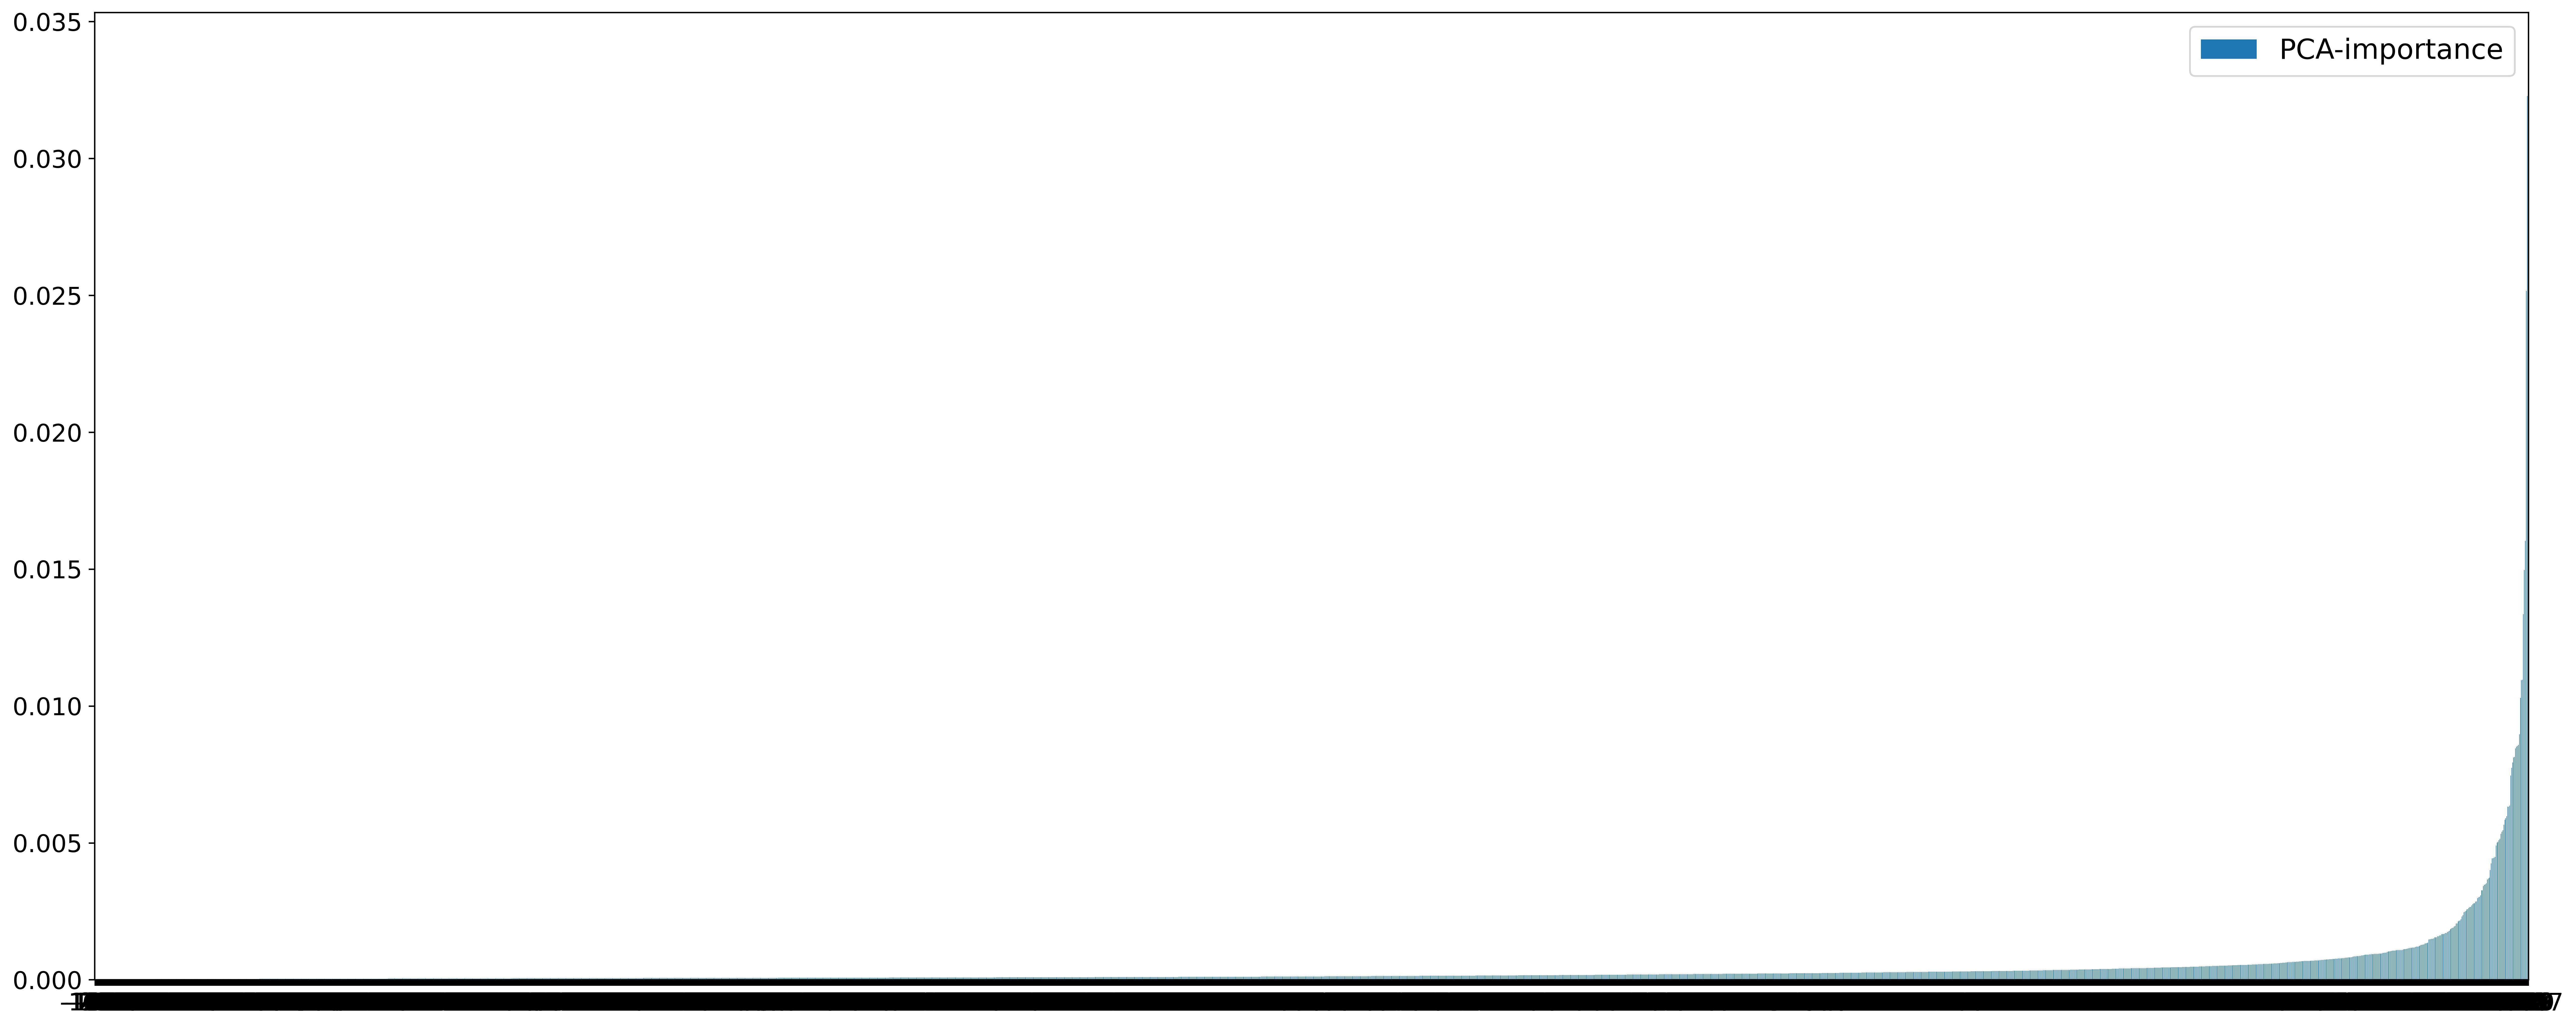

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns+1-2000, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair

imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'PCA-importance'})
imp.sort_values(by='PCA-importance').plot(kind='bar', figsize=(25, 10), rot=0)